## DeepKriging + PS on Durham data

Let's test our DeepKriging model (which adjusts for preferential sampling via MSE+BCE loss function) on the Durham data.

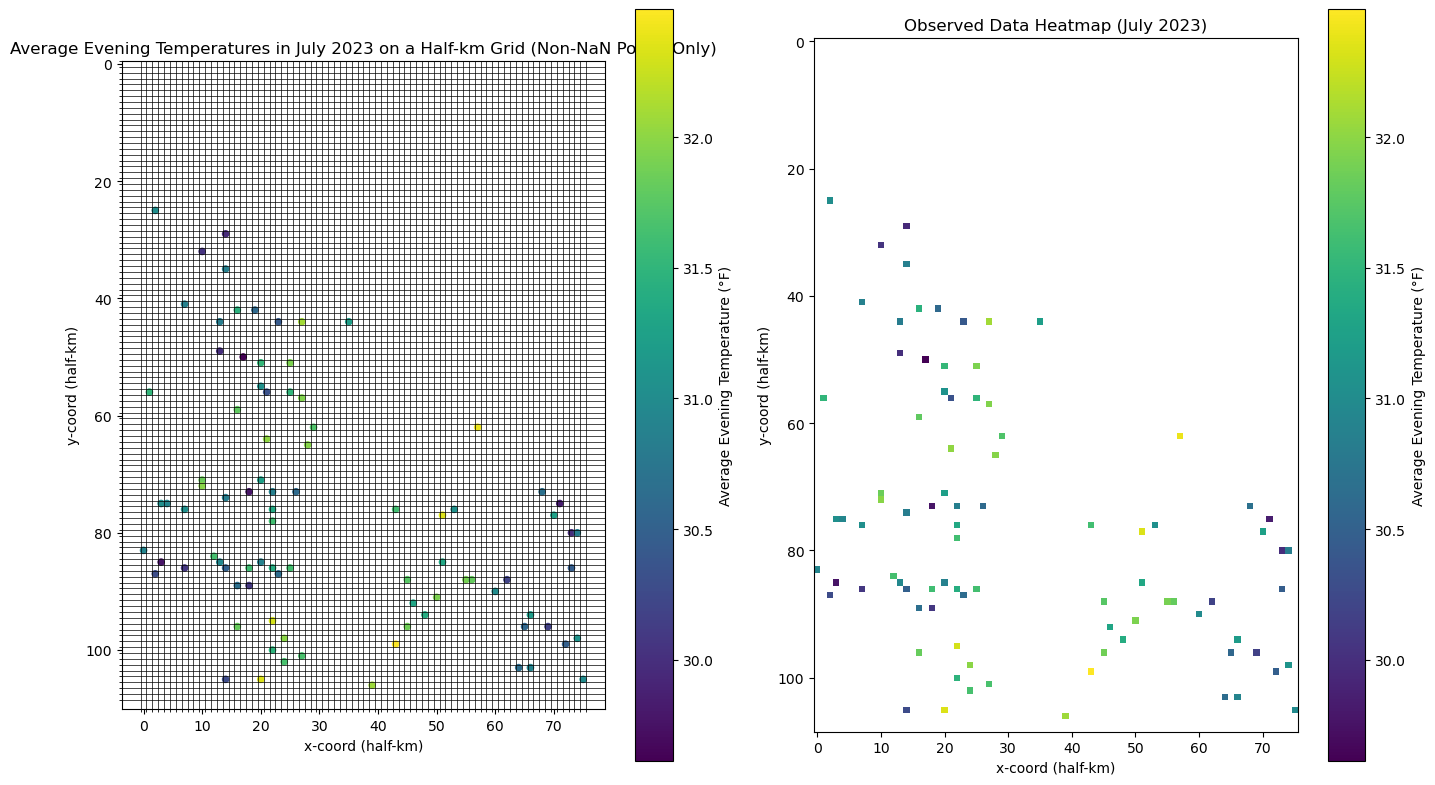

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
data = np.load('july2023_eve.npy')

# Create a figure with two horizontal subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 8))

# 1) Plot only the non-NaN data points on the first subplot
ys, xs, vals = [], [], []
for y in range(data.shape[0]):
    for x in range(data.shape[1]):
        if not np.isnan(data[y, x]):
            xs.append(x)
            ys.append(y)
            vals.append(data[y, x])

# Plot the non-NaN points with a scatter plot on the first subplot
sc = axes[0].scatter(np.array(xs), np.array(ys), c=np.array(vals), cmap='viridis', s=20)
fig.colorbar(sc, ax=axes[0], label="Average Evening Temperature (°F)")

# Set grid lines to match the 109 x 76 grid structure on the first subplot
axes[0].set_xticks(np.arange(-0.5, data.shape[1], 1), minor=True)
axes[0].set_yticks(np.arange(-0.5, data.shape[0], 1), minor=True)
axes[0].grid(which="minor", color="black", linestyle='-', linewidth=0.5)

# Set aspect to equal for consistent cell dimensions on the first subplot
axes[0].set_aspect('equal')

# Invert the y-axis for the scatter plot to match the imshow orientation
axes[0].invert_yaxis()

# Label axes and title for the first subplot
axes[0].set_title("Average Evening Temperatures in July 2023 on a Half-km Grid (Non-NaN Points Only)")
axes[0].set_xlabel("x-coord (half-km)")
axes[0].set_ylabel("y-coord (half-km)")

# 2) Visualize the observed data (heatmap) on the second subplot
im = axes[1].imshow(data, cmap='viridis', aspect='equal')
fig.colorbar(im, ax=axes[1], label="Average Evening Temperature (°F)")

# Label axes and title for the second subplot
axes[1].set_title("Observed Data Heatmap (July 2023)")
axes[1].set_xlabel("x-coord (half-km)")
axes[1].set_ylabel("y-coord (half-km)")

# Display the plots
plt.tight_layout()  # Adjust spacing between the plots
plt.show()

# note: imshow() displays images with the origin at the top-left corner (by default).








In [2]:
from itertools import product

all_grid_cell_indices = list(product(np.arange(data.shape[0]), np.arange(data.shape[1])))

print(np.arange(data.shape[0]))
print(np.arange(data.shape[1]))

# for i in product(np.arange(data.shape[0]), np.arange(data.shape[1])):
#     print(i)

print(len(all_grid_cell_indices))

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75]
8284


In [3]:
observed_grid_cell_indices = [(y, x) for y, x in all_grid_cell_indices if not np.isnan(data[y, x])]

print(len(observed_grid_cell_indices))

# for i in observed_grid_cell_indices:
#     print(i)

88


In [4]:
unobserved_grid_cell_indices = [(y, x) for y, x in all_grid_cell_indices if np.isnan(data[y, x])]

print(len(unobserved_grid_cell_indices))

# for i in unobserved_grid_cell_indices[:50]:
#     print(i)

8196


The data is plotted on a 109 row x 76 col grid, with each grid cell being a half-km square.


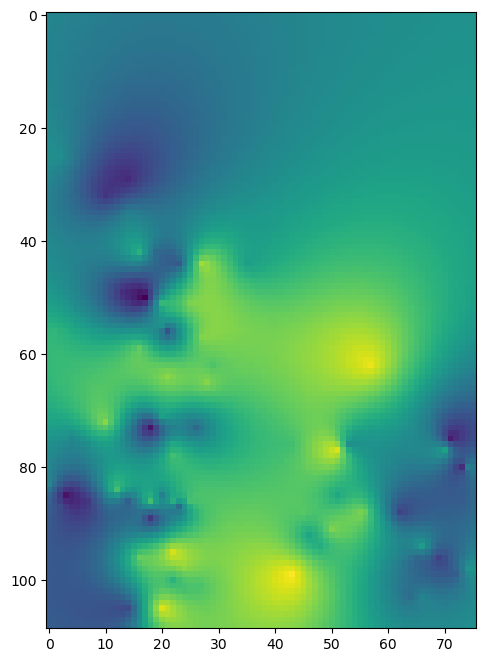

In [5]:
# Let's open up Zach's ICAR+PS predictions:
icar_ps_data = np.load('ps_mu.npy')

# plot icar_ps_data
plt.figure(figsize=(12, 8))
plt.imshow(icar_ps_data, cmap='viridis', aspect='equal')

print("The data is plotted on a 109 row x 76 col grid, with each grid cell being a half-km square.")


We have the y_trues for the observed data points, but we are obviously missing the y_trues for the unobserved data points. This is where we'll use Zach's ICAR+PS model predictions as "ground truth" values, so we can train our model in a way that minimizes loss. The goal of this is to see if we can recreate the same results as Zach's model.

88
8196
NaN count before updating unobserved cells: 8196
Non-NaN count before updating unobserved cells: 88
Number of non-NaN temp_avg values: 8284
Total number of grid cells: 8284


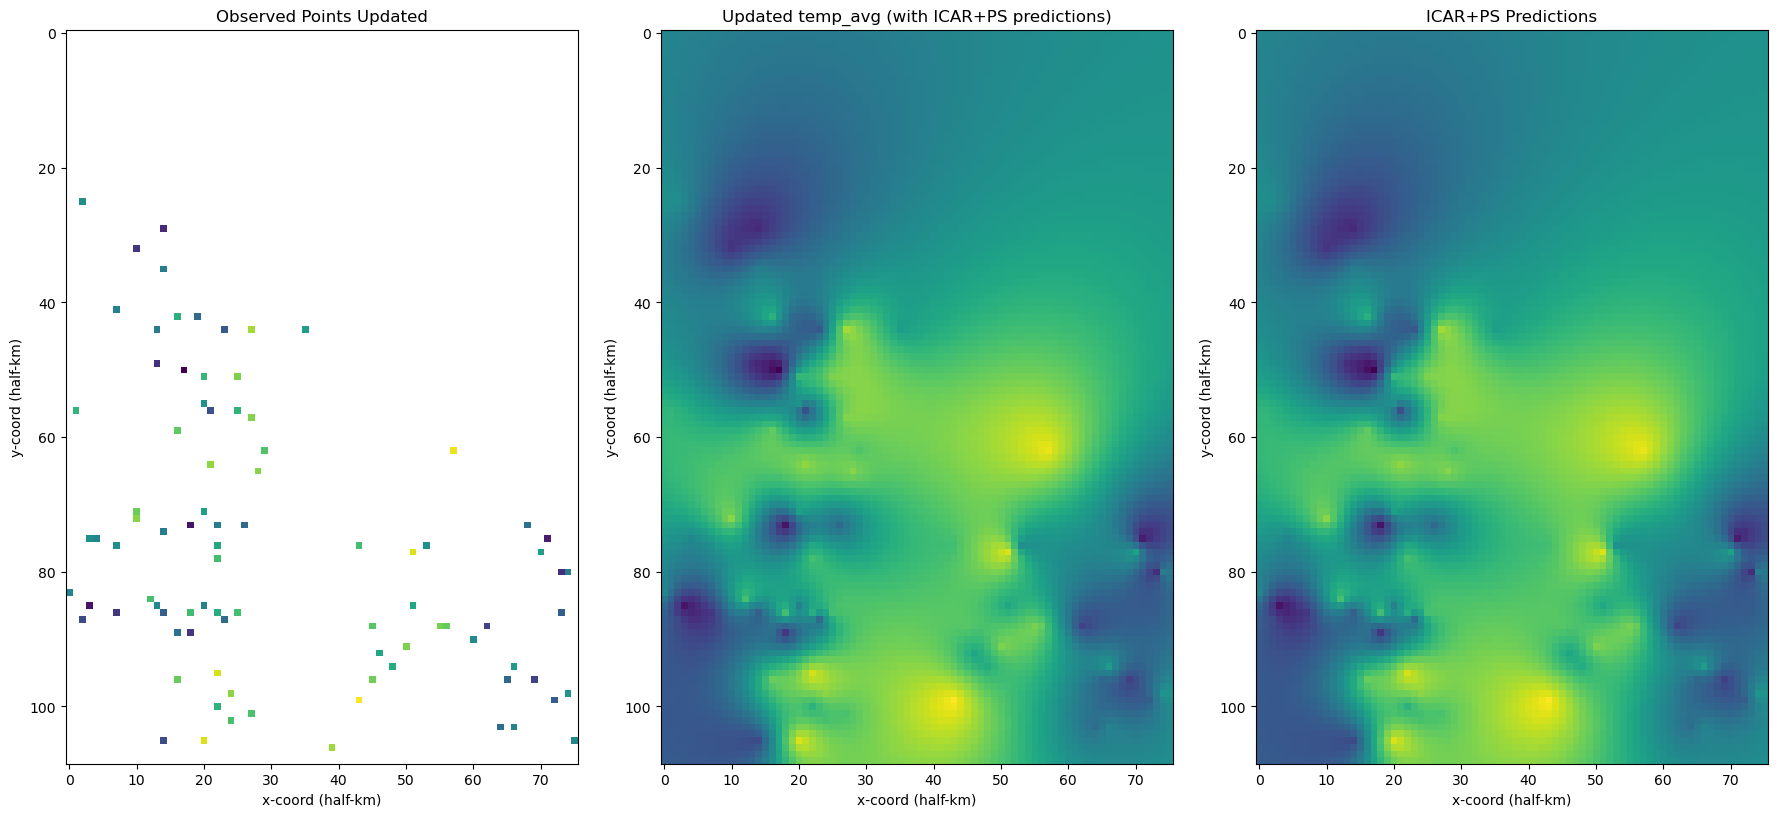

In [6]:
# NB: Zach's ICAR+PS file contains a prediction for each grid cell in the 109x76 grid.

# Let's now set the unobserved grid cells in the df to the same values as the ICAR+PS predictions.

# Initialize a dataframe that stores the grid cell indices and the temperature values (na for unobserved cells):

cells_y, cells_x = data.shape

df = pd.DataFrame(all_grid_cell_indices, columns=['grid_row', 'grid_col'])

# Initialize the 'temp_avg' column with NaN (indicating missing values initially)
df['temp_avg'] = np.nan

print(len(observed_grid_cell_indices))
print(len(unobserved_grid_cell_indices))

# First, update the 'temp_avg' column for observed grid cells
for y, x in observed_grid_cell_indices:
    # Set the temp_avg for observed points to the value from 'data'
    df.loc[(df['grid_row'] == y) & (df['grid_col'] == x), 'temp_avg'] = data[y, x]

# Check the NaN count before updating unobserved cells
print(f"NaN count before updating unobserved cells: {df['temp_avg'].isna().sum()}")
print(f"Non-NaN count before updating unobserved cells: {df['temp_avg'].notna().sum()}")

# Now, let's plot the state of the DataFrame after updating the observed cells but before adding the unobserved cells
fig, axes = plt.subplots(1, 3, figsize=(18, 8))  # 1 row, 3 columns

# Plot the observed-only updated 'temp_avg' from df (only observed points updated)
axes[0].imshow(df['temp_avg'].values.reshape(cells_y, cells_x), cmap='viridis', aspect='equal')
axes[0].set_title('Observed Points Updated')
axes[0].set_xlabel('x-coord (half-km)')
axes[0].set_ylabel('y-coord (half-km)')

# Now, update the unobserved grid cells with the ICAR+PS predictions
for y, x in unobserved_grid_cell_indices:
    # Get the prediction from icar_ps_data (note: icar_ps_data[row, col] corresponds to [y, x])
    predicted_value = icar_ps_data[y, x]
    
    # Set the temp_avg for the unobserved points to the predicted value
    df.loc[(df['grid_row'] == y) & (df['grid_col'] == x) & (df['temp_avg'].isna()), 'temp_avg'] = predicted_value

# Now, let's check if we correctly updated the 'temp_avg' column
print(f"Number of non-NaN temp_avg values: {df['temp_avg'].notna().sum()}")
print(f"Total number of grid cells: {len(df)}")


# Plot the updated 'temp_avg' after updating unobserved cells
axes[1].imshow(df['temp_avg'].values.reshape(cells_y, cells_x), cmap='viridis', aspect='equal')
axes[1].set_title('Updated temp_avg (with ICAR+PS predictions)')
axes[1].set_xlabel('x-coord (half-km)')
axes[1].set_ylabel('y-coord (half-km)')

# Plot the ICAR+PS predictions
axes[2].imshow(icar_ps_data, cmap='viridis', aspect='equal')
axes[2].set_title('ICAR+PS Predictions')
axes[2].set_xlabel('x-coord (half-km)')
axes[2].set_ylabel('y-coord (half-km)')

# Display the plots
plt.tight_layout()  # Adjust spacing between the plots
plt.show()



In [7]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

import sys
import os

# Assuming the parent directory is one level up from the current script
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.insert(0, parent_dir)

# Now you can import from custom_dk_imports
from custom_dk_imports import DeepKrigingMLP, Trainer

# Define necessary parts from nn.py
class DeepKrigingEmbedding3d(nn.Module):
    def __init__(self, K: int):
        super(DeepKrigingEmbedding3d, self).__init__()
        self.K = K
        self.num_basis = [(9*2**(h-1)+1)**2 for h in range(1,self.K+1)]
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def forward(self, s: torch.Tensor) -> torch.Tensor:
        knots_1d = [torch.linspace(0, 1, int(np.sqrt(i))).to(self.device) for i in self.num_basis]
        N = s.shape[0]
        phi = torch.zeros(N, sum(self.num_basis)).to(self.device)
        K = 0
        for res, num_basis_res in enumerate(self.num_basis):
            theta = 1 / np.sqrt(num_basis_res) * 2.5
            knots_s1, knots_s2 = torch.meshgrid(knots_1d[res], knots_1d[res], indexing='ij')
            knots = torch.stack((knots_s1.flatten(), knots_s2.flatten()), dim=1).to(self.device)
            d = torch.cdist(s, knots) / theta
            mask = (d >= 0) & (d <= 1)
            weights = torch.zeros_like(d)
            weights[mask] = ((1 - d[mask]) ** 6 * (35 * d[mask] ** 2 + 18 * d[mask] + 3) / 3)
            phi[:, K:K + num_basis_res] = weights
            K += num_basis_res
        return phi

In [8]:
import numpy as np
import torch
from sklearn.model_selection import train_test_split

import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

import sys
from custom_dk_imports import DeepKrigingMLP, Trainer, NewLoss


# extract (y, x) coordinates from 'df':
grid_points = df[['grid_row', 'grid_col']].to_numpy()
grid_points_tuples = [tuple(pt) for pt in grid_points]

print(f"Shape of grid_points: {grid_points.shape}")
for pt in grid_points_tuples: # (y, x) --> 109 rows, 76 cols
    print(pt)

temp_values = df['temp_avg'].to_numpy()



print(f"Shape of temp_values: {temp_values.shape}")
print(f"First 5 temp values: {temp_values[:5]}")


Shape of grid_points: (8284, 2)
(0, 0)
(0, 1)
(0, 2)
(0, 3)
(0, 4)
(0, 5)
(0, 6)
(0, 7)
(0, 8)
(0, 9)
(0, 10)
(0, 11)
(0, 12)
(0, 13)
(0, 14)
(0, 15)
(0, 16)
(0, 17)
(0, 18)
(0, 19)
(0, 20)
(0, 21)
(0, 22)
(0, 23)
(0, 24)
(0, 25)
(0, 26)
(0, 27)
(0, 28)
(0, 29)
(0, 30)
(0, 31)
(0, 32)
(0, 33)
(0, 34)
(0, 35)
(0, 36)
(0, 37)
(0, 38)
(0, 39)
(0, 40)
(0, 41)
(0, 42)
(0, 43)
(0, 44)
(0, 45)
(0, 46)
(0, 47)
(0, 48)
(0, 49)
(0, 50)
(0, 51)
(0, 52)
(0, 53)
(0, 54)
(0, 55)
(0, 56)
(0, 57)
(0, 58)
(0, 59)
(0, 60)
(0, 61)
(0, 62)
(0, 63)
(0, 64)
(0, 65)
(0, 66)
(0, 67)
(0, 68)
(0, 69)
(0, 70)
(0, 71)
(0, 72)
(0, 73)
(0, 74)
(0, 75)
(1, 0)
(1, 1)
(1, 2)
(1, 3)
(1, 4)
(1, 5)
(1, 6)
(1, 7)
(1, 8)
(1, 9)
(1, 10)
(1, 11)
(1, 12)
(1, 13)
(1, 14)
(1, 15)
(1, 16)
(1, 17)
(1, 18)
(1, 19)
(1, 20)
(1, 21)
(1, 22)
(1, 23)
(1, 24)
(1, 25)
(1, 26)
(1, 27)
(1, 28)
(1, 29)
(1, 30)
(1, 31)
(1, 32)
(1, 33)
(1, 34)
(1, 35)
(1, 36)
(1, 37)
(1, 38)
(1, 39)
(1, 40)
(1, 41)
(1, 42)
(1, 43)
(1, 44)
(1, 45)
(1, 46)
(1, 

Number of grid points: 8284
Index of the first grid point: 0
Index of the last grid point: 8283
Shape of observed_grid_cell_indices_flat: (88,)
First 5 indices in observed_grid_cell_indices_flat: [1902 2218 2442 2674 3123]
[0. 0.]
[1. 0.]
[2. 0.]
[3. 0.]
[4. 0.]
Shape of grid_points: (8284, 2)
Shape of M: (8284,)
Shape of temp_values: (8284,)
First 5 temp values: [30.92336692 30.91345228 30.90347219 30.89348875 30.88356934]


Text(0.5, 1.0, 'Distribution of Temperature Values')

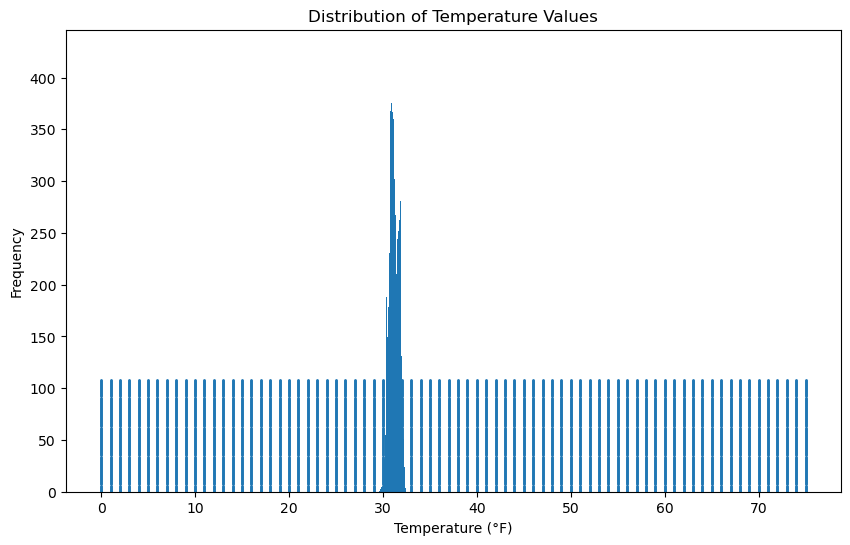

In [9]:
# create a dictionary for the gridpoint indices (assign an idx from 0 to 8283 for each gridpoint coord):
grid_point_idx_dict = {pt: idx for idx, pt in enumerate(grid_points_tuples)}
print(f"Number of grid points: {len(grid_point_idx_dict)}")
print(f"Index of the first grid point: {grid_point_idx_dict[grid_points_tuples[0]]}")
print(f"Index of the last grid point: {grid_point_idx_dict[grid_points_tuples[-1]]}")

# now make flattened version of observed_grid_cell_indices:
observed_grid_cell_indices_flat = []
for pt in observed_grid_cell_indices:
    observed_grid_cell_indices_flat.append(grid_point_idx_dict[pt])
observed_grid_cell_indices_flat = np.array(observed_grid_cell_indices_flat)
print(f"Shape of observed_grid_cell_indices_flat: {observed_grid_cell_indices_flat.shape}")
print(f"First 5 indices in observed_grid_cell_indices_flat: {observed_grid_cell_indices_flat[:5]}")

# Define the grid dimensions based on the 109x76 grid
cells_y, cells_x = 109, 76

# Create the grid points by meshing x and y coordinates
x = np.linspace(0, cells_x - 1, cells_x)  # Range for x-coordinates (0 to 75)
y = np.linspace(0, cells_y - 1, cells_y)  # Range for y-coordinates (0 to 108)
Y, X = np.meshgrid(y, x)  # Generate 2D meshgrid

# Flatten the 2D arrays of X and Y into 1D arrays and stack them
grid_points = np.vstack([Y.ravel(), X.ravel()]).T  # Shape will be (8284, 2)
for i in range(5):
    print(grid_points[i])

# plot scatterplot of grid points:
plt.figure(figsize=(10, 6))
plt.scatter(grid_points[:, 1], grid_points[:, 0], s=1)
plt.xlabel('x-coord (half-km)')
plt.ylabel('y-coord (half-km)')
plt.title('Grid Points in the 109x76 Grid')


# Initialize the M array (indicator for observed/unobserved)
M = np.zeros(len(grid_points))  # Initially, all points are unobserved (0)
M[observed_grid_cell_indices_flat] = 1  # Set observed points to 1

print(f"Shape of grid_points: {grid_points.shape}")
print(f"Shape of M: {M.shape}")

# Now grid_points is (8284, 2) and M is (8284,)

# print out temp_values:
print(f"Shape of temp_values: {temp_values.shape}")
print(f"First 5 temp values: {temp_values[:5]}")

# plot histogram of distribution of temp_values:
plt.hist(temp_values, bins=50)
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.title('Distribution of Temperature Values')

In [18]:


s_train, s_val, y_train, y_val, M_train, M_val = train_test_split(grid_points, temp_values, M, test_size=0.2, random_state=42)
s_test = grid_points  # Use the full grid as the test set

# Convert M_train and M_val back to torch tensors
M_train = torch.tensor(M_train, dtype=torch.float32)
M_val = torch.tensor(M_val, dtype=torch.float32)

# Define model parameters
num_hidden_layers = 1
hidden_dims = 100
K = 3  # embedding layer will update K based on DeepKrigingEmbedding3d

# Instantiate the embedding layer
embedding_layer = DeepKrigingEmbedding3d(K)
input_dim = sum(embedding_layer.num_basis) # 1830

# Normalize s-coords
s_min, s_max = grid_points.min(axis=0), grid_points.max(axis=0)
s_train = (s_train - s_min) / (s_max - s_min)
# s_train = s_train /100
s_val = (s_val - s_min) / (s_max - s_min)
# s_val = s_val /100
s_test = (s_test - s_min) / (s_max - s_min)
# s_test = s_test /100

# # plot scatterplot of s_train:
# plt.figure(figsize=(10, 6))
# plt.scatter(s_train[:, 1], s_train[:, 0], s=1)

print(f"s_train mean: {s_train.mean(axis=0)}, std: {s_train.std(axis=0)}")
print(f"s_train min: {s_train.min(axis=0)}, max: {s_train.max(axis=0)}")


s_train mean: [0.49523275 0.50082994], std: [0.29060189 0.29145864]
s_train min: [0. 0.], max: [1. 1.]


y_train mean: -0.00015715424624986987, std: 1.0000387276732061
y_train min: -3.1689432088490865, max: 2.609353869359781
torch.Size([6627, 2])
phi_train mean: 0.0031308233737945557, std: 0.03992723301053047
phi_train min: 0.0, max: 1.0
torch.Size([6627, 1830])
torch.return_types.max(
values=tensor([0.9164, 0.8410, 0.8953,  ..., 0.9617, 0.9424, 0.8104]),
indices=tensor([ 361, 1313,  120,  ...,   46,   81,   68]))
torch.return_types.max(
values=tensor([1.0000, 0.9971, 0.9971,  ..., 0.9901, 0.9978, 1.0000]),
indices=tensor([ 253, 5350, 6439,  ..., 1651, 5463,   46]))


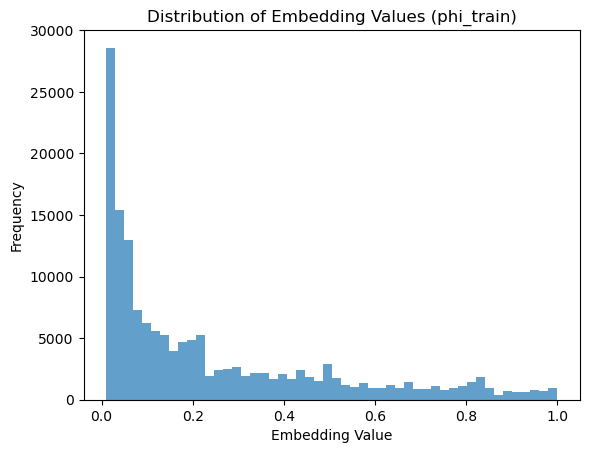

In [19]:
# Compute the mean and standard deviation of temp_values
y_mean = temp_values.mean()
y_std = temp_values.std()

# Normalize temperature values
y_train = (y_train - y_mean) / y_std
y_val = (y_val - y_mean) / y_std
y_test = (temp_values - y_mean) / y_std

print(f"y_train mean: {y_train.mean()}, std: {y_train.std()}")
print(f"y_train min: {y_train.min()}, max: {y_train.max()}")

# Convert numpy arrays to torch tensors
s_train_tensor = torch.tensor(s_train, dtype=torch.float32)
s_val_tensor = torch.tensor(s_val, dtype=torch.float32)
s_test_tensor = torch.tensor(s_test, dtype=torch.float32)
s_all_tensor = torch.tensor(s_test, dtype=torch.float32)
# print(s_train_tensor)

print(s_train_tensor.shape)

embedding_layer.eval()
# Compute the basis functions for each split using the tensor inputs
phi_train = embedding_layer(s_train_tensor)
phi_val = embedding_layer(s_val_tensor)
phi_test = embedding_layer(s_test_tensor)
phi_all = embedding_layer(s_all_tensor)

print(f"phi_train mean: {phi_train.mean().item()}, std: {phi_train.std().item()}")
print(f"phi_train min: {phi_train.min().item()}, max: {phi_train.max().item()}")

print(phi_train.shape)
print(torch.max(phi_train, dim=1))
print(torch.max(phi_train, dim=0))


import matplotlib.pyplot as plt

phi_train_np = phi_train.detach().cpu().numpy().flatten()
plt.hist(phi_train_np[phi_train_np > 0.01], bins=50, alpha=0.7)

plt.title("Distribution of Embedding Values (phi_train)")
plt.xlabel("Embedding Value")
plt.ylabel("Frequency")
plt.show()

# Convert y_train, y_val, and y_test to torch tensors
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_val = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(temp_values, dtype=torch.float32).view(-1, 1)
y_all_tensor = torch.tensor(temp_values, dtype=torch.float32).view(-1, 1)


deepkriging_model = DeepKrigingMLP(input_dim, num_hidden_layers, hidden_dims, K=K, activation='relu')

train_loader = torch.utils.data.DataLoader(
    dataset=torch.utils.data.TensorDataset(phi_train, y_train),
    batch_size=32, shuffle=True
)

val_loader = torch.utils.data.DataLoader(
    dataset=torch.utils.data.TensorDataset(phi_val, y_val),
    batch_size=32, shuffle=False
)

test_loader = torch.utils.data.DataLoader(
    dataset=torch.utils.data.TensorDataset(phi_test, y_test),
    batch_size=32, shuffle=False
)

data_generators = {'train': train_loader, 'val': val_loader, 'test': test_loader}

In [12]:
# noise_var = 0.01  # Nugget variance

# from sklearn.gaussian_process import GaussianProcessRegressor
# from sklearn.gaussian_process.kernels import RBF, Matern

# kernel = 1 * Matern(length_scale=10, nu=1.5)
# gp = GaussianProcessRegressor(kernel=kernel, alpha=noise_var)

# # print(y_train[M_train.numpy().astype(bool)])

# gp.fit(s_train[M_train.numpy().astype(bool)], y_train[M_train.numpy().astype(bool)])   
# y_pred_gp, y_std_gp = gp.predict(grid_points, return_std=True)

# print(y_pred_gp.shape)
# print(y_std_gp)

# X = np.arange(0, 76, 1)
# Y = np.arange(0, 109, 1)
# process_values_grid = temp_values.reshape(109, 76)

# # plot gp with contourf:
# plt.figure(figsize=(12, 8))
# plt.contourf(Y, X, y_pred_gp.reshape(109, 76), cmap='viridis')
# plt.colorbar()
# plt.title('GP Prediction')
# plt.xlabel('x-coord (half-km)')
# plt.ylabel('y-coord (half-km)')
# plt.show()

Training started:

Epoch 1/100
Learning rate: 0.000100
0s for 208 steps - 1ms/step - loss 1.2635
Validation:
0s - loss 1.1870

Epoch 2/100
Learning rate: 0.000100
0s for 208 steps - 2ms/step - loss 1.1328
Validation:
0s - loss 1.0709

Epoch 3/100
Learning rate: 0.000100
0s for 208 steps - 1ms/step - loss 1.0592
Validation:
0s - loss 1.0371

Epoch 4/100
Learning rate: 0.000100
0s for 208 steps - 1ms/step - loss 1.0328
Validation:
0s - loss 1.0270

Epoch 5/100
Learning rate: 0.000100
0s for 208 steps - 1ms/step - loss 1.0172
Validation:
0s - loss 1.0248

Epoch 6/100
Learning rate: 0.000100
0s for 208 steps - 1ms/step - loss 1.0073
Validation:
0s - loss 1.0246

Epoch 7/100
Learning rate: 0.000100
0s for 208 steps - 1ms/step - loss 1.0002
Validation:
0s - loss 1.0249

Epoch 8/100
Learning rate: 0.000100
0s for 208 steps - 2ms/step - loss 0.9922
Validation:
0s - loss 1.0265

Epoch 9/100
Learning rate: 0.000100
0s for 208 steps - 1ms/step - loss 0.9863
Validation:
0s - loss 1.0286

Epoch 10/

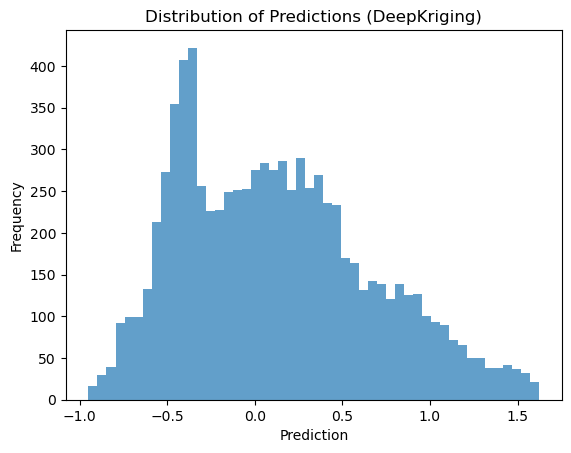

In [20]:
from custom_dk_imports import NewLoss
trainer = Trainer(
    model=deepkriging_model,
    data_generators={'train': train_loader, 'val': val_loader, 'test': test_loader},
    optim='adam',
    optim_params={'lr': 1e-4},
    loss_fn=NewLoss(s_all=grid_points, observed_indices=observed_grid_cell_indices_flat, y_all=temp_values),
    # loss_fn=nn.MSELoss(),
    M_train=M_train,
    M_val=M_val,
    window_size=10,
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    epochs=100,
    patience=10
)

trainer.train()

deepkriging_model.eval()

with torch.no_grad():
    y_pred_deepkriging = deepkriging_model(phi_all).cpu().numpy()

print(f"y_pred_deepkriging shape: {y_pred_deepkriging.shape}")
print(f"First few predictions: {y_pred_deepkriging[:5]}")

plt.hist(y_pred_deepkriging, bins=50, alpha=0.7)
plt.title("Distribution of Predictions (DeepKriging)")
plt.xlabel("Prediction")
plt.ylabel("Frequency")
plt.show()


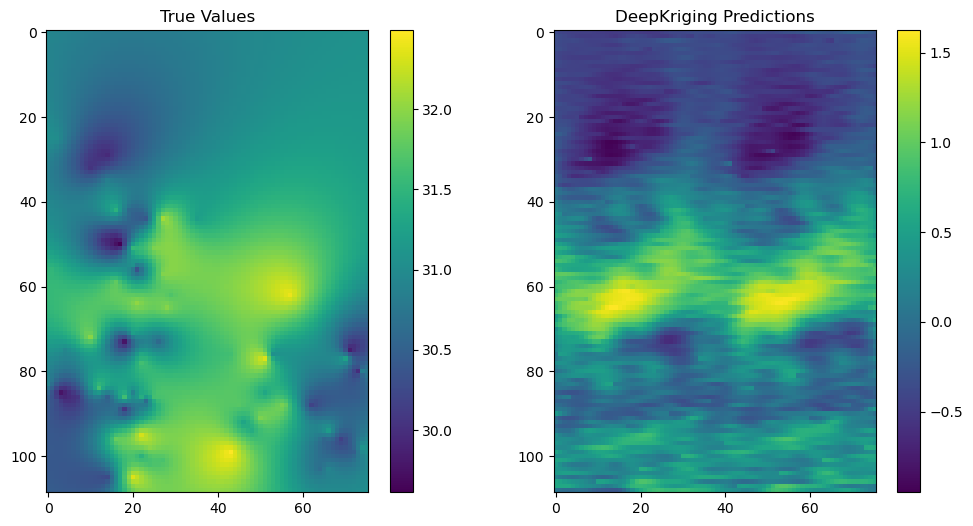

In [21]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(temp_values.reshape(109, 76), cmap='viridis')
plt.title('True Values')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(y_pred_deepkriging.reshape(109, 76), cmap='viridis')
plt.title('DeepKriging Predictions')
plt.colorbar()

plt.show()


In [15]:
noise_var = 0.01  # Nugget variance

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern

# kernel = 1 * Matern(length_scale=0.05, nu=1.5)
kernel = 1 * RBF(length_scale=0.05)
gp = GaussianProcessRegressor(kernel=kernel, alpha=noise_var)

print(y_train[M_train.numpy().astype(bool)])

gp.fit(s_train[M_train.numpy().astype(bool)], y_train[M_train.numpy().astype(bool)])   
y_pred_gp, y_std_gp = gp.predict(grid_points, return_std=True)

tensor([[-1.1738],
        [ 1.1972],
        [ 1.6506],
        [-0.3251],
        [ 0.0700],
        [-0.2928],
        [-3.1689],
        [ 1.5211],
        [-0.5584],
        [ 2.3146],
        [-0.7268],
        [ 2.4409],
        [-2.8580],
        [-2.0029],
        [ 0.8538],
        [-2.4175],
        [ 0.1154],
        [ 1.4757],
        [-1.4588],
        [-0.4029],
        [-0.2668],
        [ 0.5105],
        [ 0.4263],
        [ 0.2643],
        [-0.7138],
        [-2.4693],
        [-0.6296],
        [ 0.6725],
        [ 1.4239],
        [ 0.6336],
        [-1.1155],
        [ 1.2425],
        [-1.1997],
        [-0.6814],
        [ 0.9510],
        [-0.4709],
        [-0.1826],
        [ 0.5688],
        [-2.8450],
        [-0.5389],
        [-2.2296],
        [ 1.0158],
        [ 1.5772],
        [-1.2450],
        [-2.3981],
        [-2.6961],
        [ 0.8538],
        [-0.2345],
        [-2.3009],
        [-2.2297],
        [ 1.8061],
        [-0.5260],
        [ 1.

/usr/local/Caskroom/miniforge/base/envs/torch-env/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


In [16]:
y_pred_gp

array([0., 0., 0., ..., 0., 0., 0.])

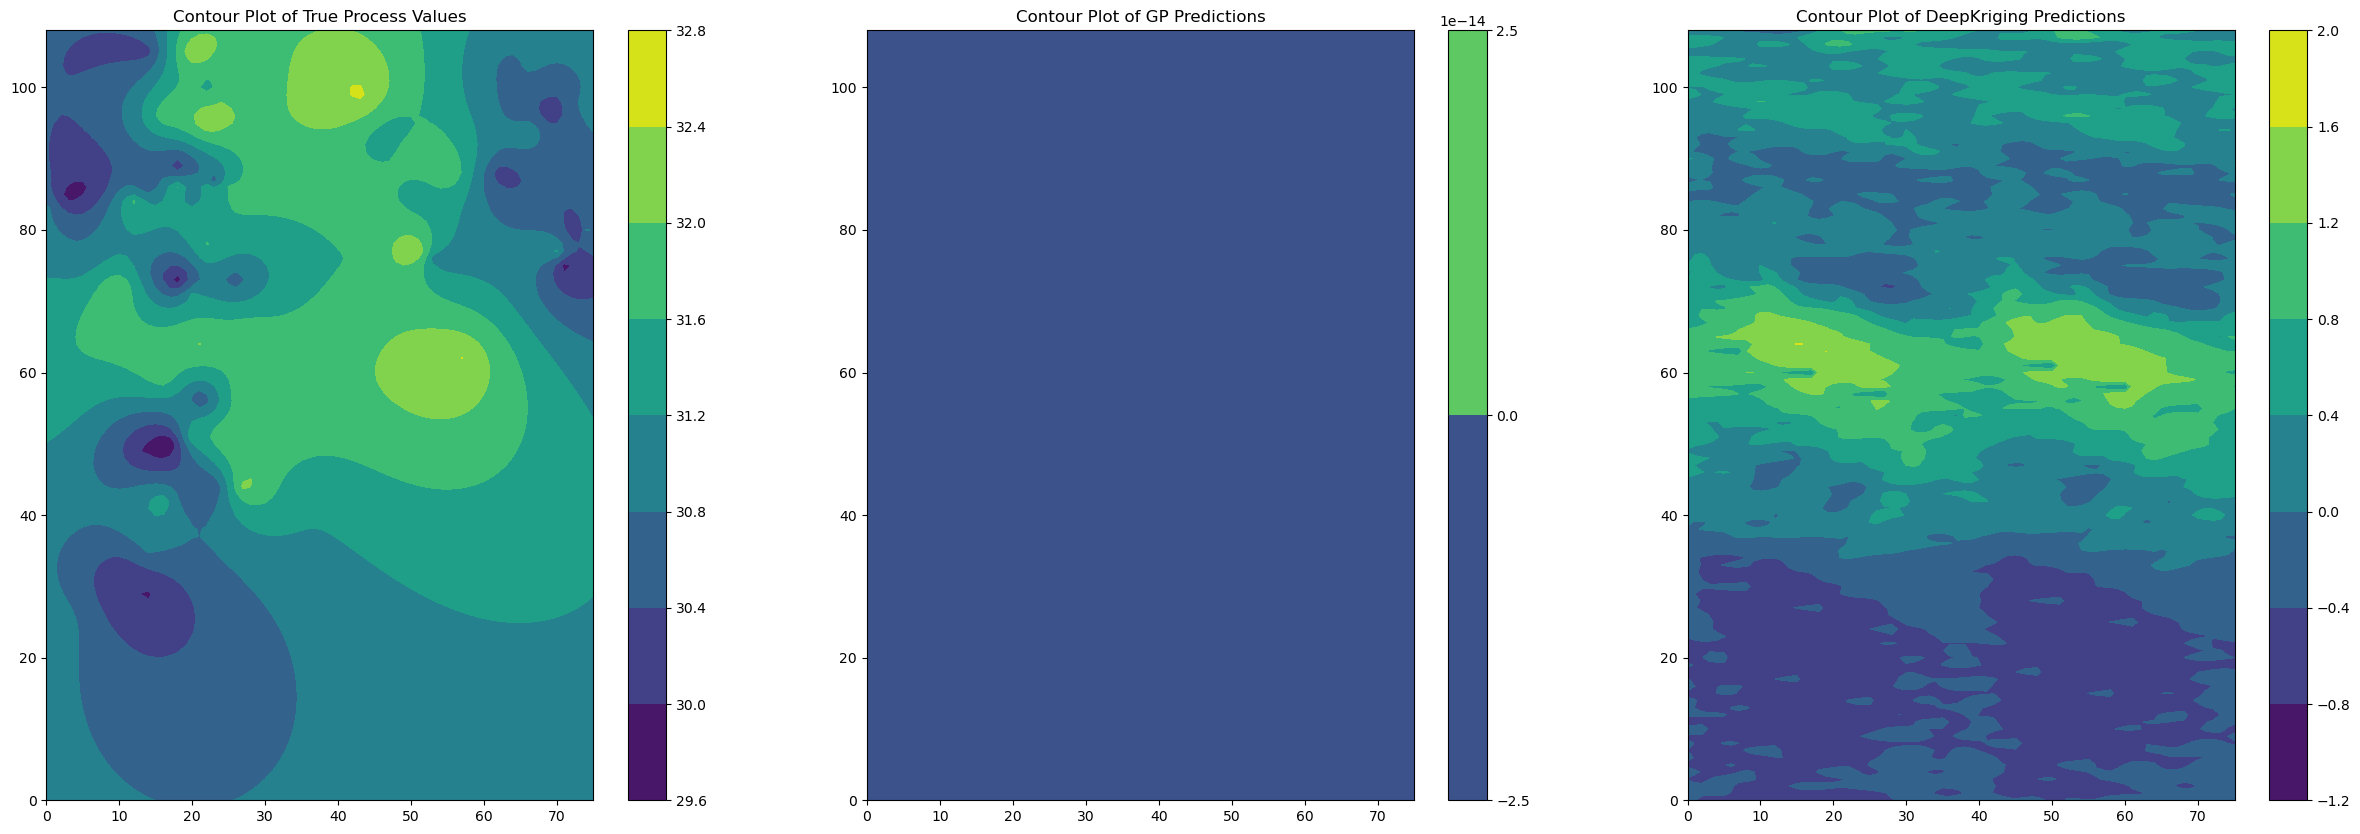

In [17]:
import matplotlib.gridspec as gridspec
# import pykrige


fig = plt.figure(figsize=(30, 10))
gs = gridspec.GridSpec(1, 3)
ax = plt.subplot(gs[0, 0])

X = np.arange(0, 76, 1)
Y = np.arange(0, 109, 1)
process_values_grid = temp_values.reshape(109, 76)

contour1 = ax.contourf(X, Y, process_values_grid, cmap='viridis')
cbar1 = plt.colorbar(contour1, ax=ax)
ax.set_title("Contour Plot of True Process Values")

ax = plt.subplot(gs[0, 1])
# # Plot DeepKriging predictions directly on the test points
contour2 = ax.contourf(X, Y, y_pred_gp.reshape(109, 76), cmap='viridis')
cbar2 = plt.colorbar(contour2, ax=ax)
ax.set_title("Contour Plot of GP Predictions")

ax = plt.subplot(gs[0, 2])
# # Plot GP predictions directly on the test points
contour3 = ax.contourf(X, Y, y_pred_deepkriging.reshape(109, 76), cmap='viridis')
cbar3 = plt.colorbar(contour3, ax=ax)
ax.set_title("Contour Plot of DeepKriging Predictions")



plt.show()